In [273]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from poker_utils.hands import card_distance
import seaborn as sns


In [274]:
def plot_latent_space(latent_data, figsize=(14, 6)):
   
    fig, axs = plt.subplots(1, 2, figsize=figsize)

    ax0 = sns.scatterplot(
        data=latent_data,
        x='mean1',
        y='mean2',
        hue='hand_type', 
        palette='Set1',
        s=80,        
        alpha=0.8,
        ax=axs[0]
    )
    
    axs[0].set_title("Hand Latent Space")
    for i, hand in enumerate(latent_data.hand):
        axs[0].annotate(
            hand, 
            (latent_data['mean1'][i].item(), latent_data['mean2'][i].item()),
            fontsize=8
        )
    
    axs[0].legend(title='Hand Type', loc='best')
    axs[1].hist(latent_data['mean1'], bins=20, alpha=0.7, label='Dimension 1')
    axs[1].hist(latent_data['mean2'], bins=20, alpha=0.7, label='Dimension 2')
    axs[1].set_title("Latent Dimensions Distribution")
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

In [275]:
def plot_train_loss(train_res):
    epochs = len(train_res['kl_loss'])
    plt.figure(figsize=(5, 5))
    plt.plot(range(epochs), train_res['total_loss'], 'b-', label='Total Loss')
    plt.title('Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_res['reconstruction_loss'], 'r-')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_res['kl_loss'], 'b-')
    plt.title('KL Divergence Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.tight_layout()
    plt.show()

In [276]:
def get_latent_space_data(model, trainloader):
    def get_hand_type(hand):
        if hand[-1] == 's':
            return 'suited'
        if hand[0] == hand[1]:
            return 'pair'
        else:
            return 'offsuit'
    model.eval()
    batch = next(iter(trainloader))
    with torch.no_grad():
        mean, logvar, _ = model(batch[1])
    data = pd.DataFrame({
        'hand': batch[0],
        'mean1': mean[:,0],
        'mean2': mean[:,1],
        'logvar1': logvar[:,0],
        'logvar2': logvar[:,1]
        })
        
    data['hand_type'] = data['hand'].apply(get_hand_type)
    data['connectedness'] = data.apply(lambda x: card_distance(x.hand), axis=1)
    return data

In [277]:
attribute_colums = ['hand_type','suited','pair','connectedness','high_card','low_card']
equity_columns = ['flop_equity', 'turn_equity','river_equity', 'equity_delta']
dom_block_columns = [
    'dominates_count', 'combos_dominated', 'blocks_count',
    'blocked_by_count', 'combos_blocked_by_count', 'dominated_by_count',
    'combos_dominated_by_count', 'dom_ratio', 'block_ratio',
    'dom_block_ratio', 'block_ratio_cat'
    ]
# 'combos_blocked' same for all hands
pc_cols = ['dom_block_pc1', 'dom_block_pc2','ev_pc1', 'ev_pc2']

In [278]:
ev_columns = [
    'BB_play10', 'BB_play2', 'BB_play3', 'BB_play4', 'BB_play5', 'BB_play6',
    'BB_play7', 'BB_play8', 'BB_play9', 'D_play10', 'D_play3', 'D_play4',
    'D_play5', 'D_play6', 'D_play7', 'D_play8', 'D_play9', 'SB_play10',
    'SB_play2', 'SB_play3', 'SB_play4', 'SB_play5', 'SB_play6', 'SB_play7',
    'SB_play8', 'SB_play9', 'pos3_play10', 'pos3_play4', 'pos3_play5',
    'pos3_play6', 'pos3_play7', 'pos3_play8', 'pos3_play9', 'pos4_play10',
    'pos4_play5', 'pos4_play6', 'pos4_play7', 'pos4_play8', 'pos4_play9',
    'pos5_play10', 'pos5_play6', 'pos5_play7', 'pos5_play8', 'pos5_play9',
    'pos6_play10', 'pos6_play7', 'pos6_play8', 'pos6_play9', 'pos7_play10',
    'pos7_play8', 'pos7_play9', 'pos8_play10', 'pos8_play9', 'pos9_play10'
    ]

In [279]:
class HandDataset(Dataset):
    
    def __init__(self, data_path, columns: list):
        cols = ['hand'] + columns
        self.feature_columns = columns
        self.data = pd.read_csv(data_path, usecols=cols)
        if 'hand_type' in columns:
            self.data['hand_type'] = self.data['hand_type'].map({'pair': 0, 'suited': 1, 'offsuit': 2})
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        hand = row['hand']
        X_np = row[self.feature_columns].values.astype(np.float32)
        return hand, torch.tensor(X_np, dtype=torch.float32)
        

In [280]:
class HandVAE(nn.Module):
    def __init__(self, input_dim=62, hidden_dim=32, latent_dim=2):
        super(HandVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU()
        )
        self.mean_fc = nn.Linear(hidden_dim//2, latent_dim)
        self.logvar_fc = nn.Linear(hidden_dim//2, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def encode(self, x):
        encoded_x = self.encoder(x)
        mean = self.mean_fc(encoded_x)
        logvar = self.logvar_fc(encoded_x)
        return mean, logvar
    
    def sample(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        z = torch.randn_like(std)
        z = z * std + mean
        return z
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.sample(mean, logvar)
        return mean, logvar, self.decoder(z)
    

In [281]:
def loss_func(x_recon, x_input, mean, logvar, beta=3.0):
    recon_loss = torch.nn.functional.mse_loss(x_recon, x_input, reduction='sum')
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(logvar) + mean**2 - 1 - logvar, dim=-1))
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

In [282]:
def train_model(model, dataloader, optimizer, beta=3.0, epochs=10):
    recon_losses = []
    kl_losses = []
    total_losses = []
    
    model.train()
    for epoch in range(epochs):
        for cards, features in dataloader:
            optimizer.zero_grad()
            mean, logvar, x_recon = model(features)
            total_loss, recon_loss, kl_loss = loss_func(x_recon, features, mean, logvar, beta=beta)
            total_loss.backward()
            optimizer.step()
  
            recon_losses.append(recon_loss.item())
            kl_losses.append(kl_loss.item())
            total_losses.append(total_loss.item())
        
        if epoch % (epochs//5) == 0:
            print(f"Epoch {epoch+1}/{epochs}, Total Loss: {total_loss.item():.4f}, "
              f"Recon Loss: {recon_loss.item():.4f}, KL Loss: {kl_loss.item():.4f}")
    
    return {
        'reconstruction_loss': recon_losses,
        'kl_loss': kl_losses,
        'total_loss': total_losses
    }

In [283]:
features = ev_columns + equity_columns + ['hand_type', 'connectedness', 'high_card', 'low_card']

In [284]:
data = HandDataset(
    data_path='data/processed/full_data.csv', 
    columns=features)
dataloader = DataLoader(data, batch_size=169, shuffle=True)

In [285]:
model = HandVAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50

train_res = train_model(model, dataloader, optimizer, beta=1.0, epochs=epochs)

Epoch 1/50, Total Loss: 23079.9707, Recon Loss: 23079.7207, KL Loss: 0.2491
Epoch 11/50, Total Loss: 21220.0195, Recon Loss: 21219.8340, KL Loss: 0.1864
Epoch 21/50, Total Loss: 19799.4336, Recon Loss: 19799.1855, KL Loss: 0.2482
Epoch 31/50, Total Loss: 18619.7129, Recon Loss: 18619.4395, KL Loss: 0.2738
Epoch 41/50, Total Loss: 17489.1484, Recon Loss: 17488.7383, KL Loss: 0.4102


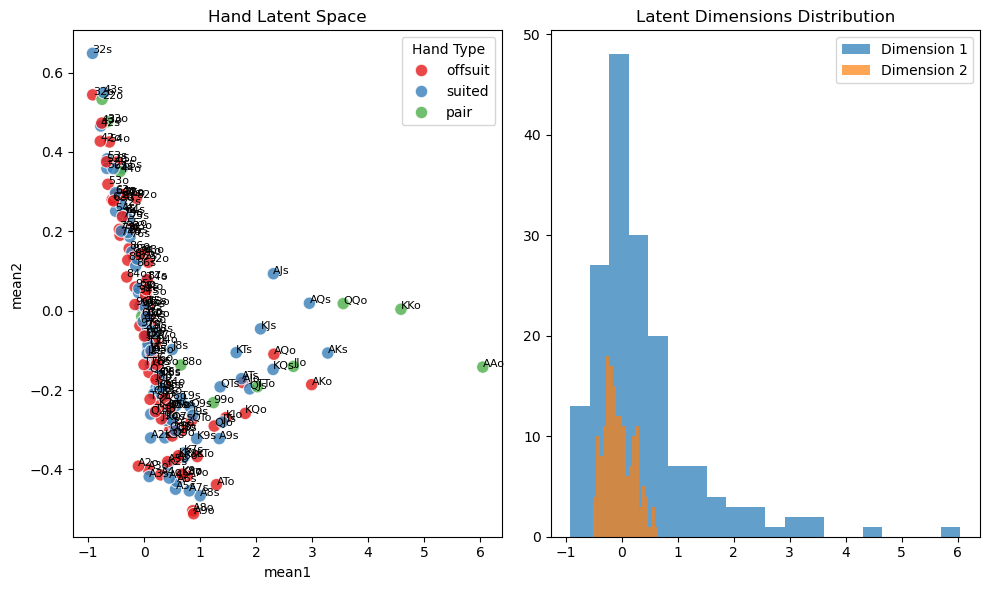

In [286]:
latent_data = get_latent_space_data(model, dataloader)
plot_latent_space(latent_data, (10,6))

In [287]:
model = HandVAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50

train_res = train_model(model, dataloader, optimizer, beta=3.0, epochs=epochs)

Epoch 1/50, Total Loss: 24541.7969, Recon Loss: 24540.8809, KL Loss: 0.3051
Epoch 11/50, Total Loss: 22278.9453, Recon Loss: 22273.7402, KL Loss: 1.7352
Epoch 21/50, Total Loss: 20622.2148, Recon Loss: 20616.5371, KL Loss: 1.8928
Epoch 31/50, Total Loss: 19496.8926, Recon Loss: 19492.8262, KL Loss: 1.3553
Epoch 41/50, Total Loss: 18410.5684, Recon Loss: 18406.7715, KL Loss: 1.2658


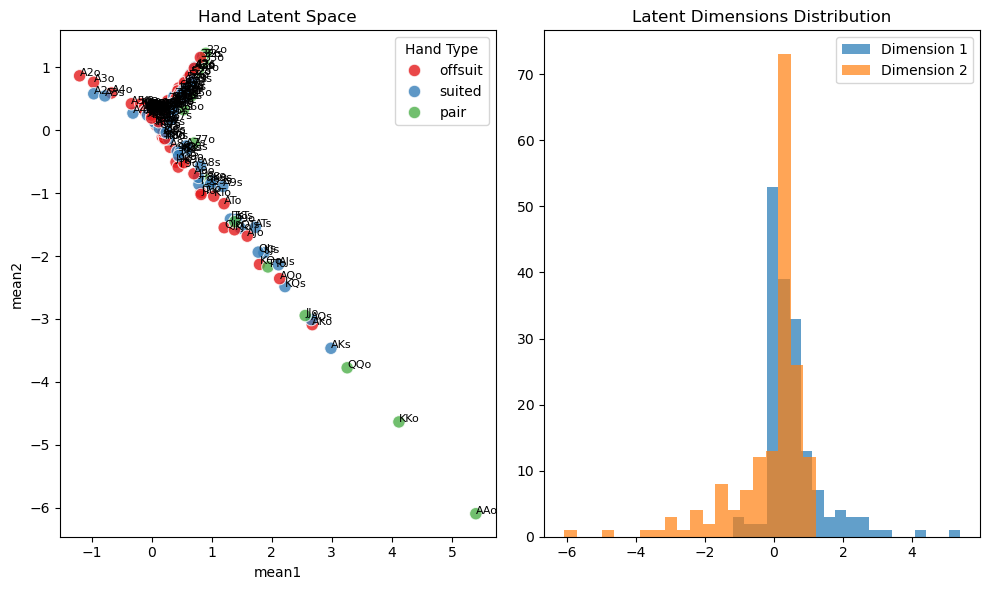

In [288]:
latent_data = get_latent_space_data(model, dataloader)
plot_latent_space(latent_data, (10,6))

In [289]:
model = HandVAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50

train_res = train_model(model, dataloader, optimizer, beta=5.0, epochs=epochs)

Epoch 1/50, Total Loss: 23951.4219, Recon Loss: 23950.4238, KL Loss: 0.1998
Epoch 11/50, Total Loss: 22171.1738, Recon Loss: 22169.4492, KL Loss: 0.3449
Epoch 21/50, Total Loss: 20934.0215, Recon Loss: 20931.4902, KL Loss: 0.5064
Epoch 31/50, Total Loss: 19762.5586, Recon Loss: 19759.3105, KL Loss: 0.6497
Epoch 41/50, Total Loss: 18542.8750, Recon Loss: 18538.7793, KL Loss: 0.8193


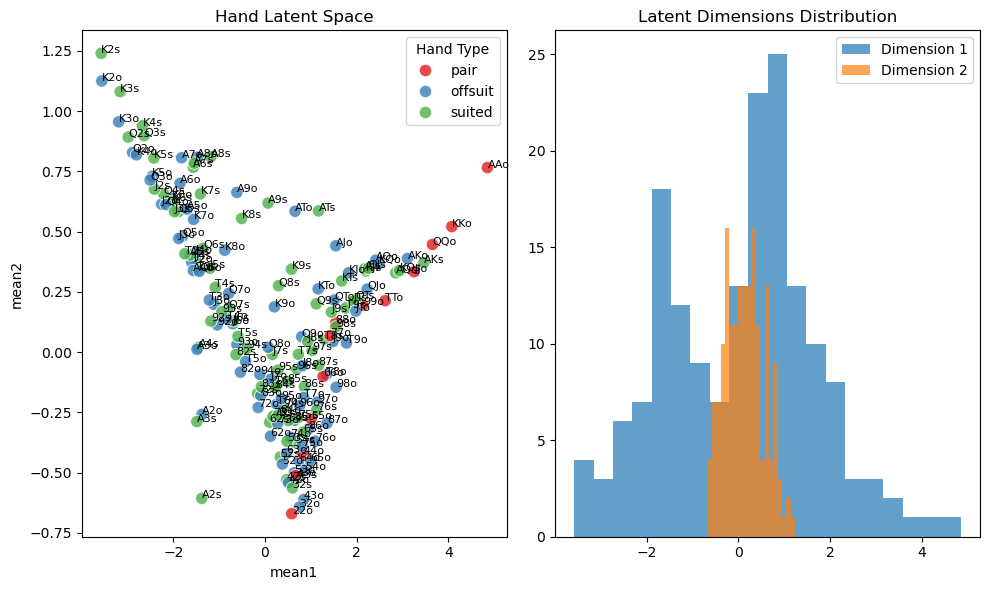

In [290]:
latent_data = get_latent_space_data(model, dataloader)
plot_latent_space(latent_data, (10,6))